### импорт библиотек

In [17]:
!pip install matplotlib

  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached contourpy-1.0.7-cp311-cp311-win_amd64.whl (162 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.39.3-py3-none-any.whl (1.0 MB)
  Using cached kiwisolver-1.4.4-cp311-cp311-win_amd64.whl (55 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [18]:
import pandas as pd
import numpy as np
import re
import tqdm
import yaml


from pymystem3 import Mystem
from razdel import tokenize, sentenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### загрузка стоп-слов (с сайта https://snipp.ru/seo/stop-ru-words)

In [19]:
# load stopwords
with open('ru_stopwords.yaml', 'r') as f:
    ru_stopwords = yaml.safe_load(f)

### Загрузка датасета

# 16

In [20]:
age = 16
gender = 1

In [21]:
dataset_path = f'datasets/{age}_{gender}_0_150.csv'
dataset = pd.read_csv(dataset_path, delimiter='\t')
dataset.head()

,text,gender,age,numwords,userid,year
0,Обращаюсь к своим ненавистникам!þ<br />þЕсли в...,1,16,39,195147735,2014
1,"Очередной ""шедевр"", господа.þ<br />þþ<br />þМо...",1,16,37,195147735,2015
2,"Закрой глаза на все обиды,þ<br />þИ все конфли...",1,16,31,195147735,2015
3,"Не зная правды...þ<br />þЛезите в огонь, чтобы...",1,16,9,195147735,2015
4,"Я люблю твою улыбку,þ<br />þЯ люблю твои глаза...",1,16,43,195147735,2015


In [22]:
print(len(dataset))

5897495


In [23]:
dataset_short = dataset if len(dataset) <= 500000 else dataset.sample(500000)
dataset_short.replace('þ<br />þ', '\n ', regex=True, inplace=True)
dataset_short.head()

,text,gender,age,numwords,userid,year
993207,я тебе сказала про него вообще то...\n хоть и ...,1,16,10,54746932,2010
4369180,Было время.. \n В детском саду,1,16,5,181750473,2015
3110529,Я думала над тем что надо что то менять в свое...,1,16,18,142966253,2012
5730700,Хехех играем в критику фотки мотки в лсактива ...,1,16,15,345536219,2016
82095,Вез зочк,1,16,2,317595029,2016


In [24]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc), deacc=True) if word not in ru_stopwords] for doc in texts]

def preprocess_fast(texts, step=10):
    i = 0
    texts_without_stopwords = [" ".join(txt) for txt in remove_stopwords(data)]
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts_without_stopwords, step)
    res = []
    for txtp in tqdm.tqdm(txtpart):
        alltexts = ' '.join([txt + ' br ' for txt in txtp])

        words = stem.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'br':
                    res.append(doc)
                    doc = []
                else:
                    doc.append(txt)
    return res

def preprocess(text):
    tokens = stem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in ru_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    # text = " ".join(tokens)
    
    return token

In [25]:
stem = Mystem()
data = dataset_short['text'].tolist()
preprocessed_fast_data = preprocess_fast(data, 10000)

Installing mystem to C:\Users\Димас/.local/bin\mystem.exe from http://download.cdn.yandex.net/mystem/mystem-3.1-win-64bit.zip
100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


In [26]:
j = 5
preprocessed_fast_data[-j:], data[-j:]

([['отличный',
   'фото',
   'стакие',
   'фото',
   'раса',
   'фото',
   'батлы',
   'игра',
   'конкурс',
   'набор',
   'редактор',
   'условие',
   'приглашать',
   'попадать',
   'редактор',
   'миг',
   'дружный',
   'админ',
   'редактор',
   'актив',
   'группа',
   'создавать',
   'нету',
   'набирать',
   'чу',
   'людей',
   'весело',
   'http',
   'vk',
   'com',
   'club'],
  ['любовь',
   'преображать',
   'человек',
   'истинный',
   'чувство',
   'помогать',
   'высвечивать',
   'человеческои',
   'личность',
   'хороший',
   'нея',
   'закладывать',
   'природой',
   'воспитание',
   'проживать',
   'год'],
  ['чарджер'],
  ['сходить',
   'ум',
   'гарри',
   'поттер',
   'прекращать',
   'собираться',
   'ибо',
   'хогвартс',
   'хогвартс'],
  ['лето', 'наслаждаться']],
 ['привет у тебя отличные фото да стакими фото тебе надо к нам у нас как рас фото батлы ⭐ у нас игры конкурсы а ещё у нас набор в редакторы только 1-условие \n пригласи 5 человек и попадёшь в редактор

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(preprocessed_fast_data)
# Create Corpus
texts = preprocessed_fast_data
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])


[[(0, 1)]]


In [28]:
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

In [29]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=1, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
for i in lda_model.print_topics():
    print(i)
with open(f'topics_1_500000_{age}_{gender}.yaml', 'w') as file:
    yaml.dump(dict(lda_model.print_topics()), file)

(0, '0.013*"любить" + 0.005*"хороший" + 0.005*"id" + 0.004*"день" + 0.004*"любовь" + 0.004*"друг" + 0.003*"com" + 0.003*"любимый" + 0.003*"http" + 0.003*"знать"')


In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
for i in lda_model.print_topics():
    print(i)
with open(f'topics_2_500000_{age}_{gender}.yaml', 'w') as file:
    yaml.dump(dict(lda_model.print_topics()), file)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

(0, '0.009*"com" + 0.008*"http" + 0.007*"купить" + 0.007*"vk" + 0.006*"завтра" + 0.006*"лизун" + 0.006*"реакция" + 0.006*"школа" + 0.005*"че" + 0.005*"_"')
(1, '0.021*"любить" + 0.008*"хороший" + 0.007*"id" + 0.007*"день" + 0.006*"любовь" + 0.006*"друг" + 0.005*"любимый" + 0.005*"знать" + 0.005*"забывать" + 0.004*"рождение"')


c:\Users\Димас\venvs\main_venv\Lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.254253  0.0       1        1  63.766792
0     -0.254253  0.0       2        1  36.233208, topic_info=         Term          Freq         Total Category  logprob  loglift
21     любить  50571.000000  50571.000000  Default  30.0000  30.0000
185       com  11696.000000  11696.000000  Default  29.0000  29.0000
187      http  11272.000000  11272.000000  Default  28.0000  28.0000
132    купить   9445.000000   9445.000000  Default  27.0000  27.0000
188        vk   8851.000000   8851.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
72670   лизун   8003.931690   8498.785305   Topic2  -5.1180   0.9552
1067    класс   3966.672288   4218.571874   Topic2  -5.8200   0.9536
756      фото   5604.062577   7941.116892   Topic2  -5.4745   0.6666
16      фотка   3450.497679   3939.605576   Topic2  -5.9595   0.8826
1197   писать   5014.975982   7891.947212   Topic2  -5.5855   0.5618

[109 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1734      1  0.000160        _
1734      2  0.999979        _
2245      1  0.000378      amp
2245      2  0.999612      amp
184       1  0.000350     club
...     ...       ...      ...
180       2  0.000189  чувство
1093      1  0.000268    школа
1093      2  0.999790    школа
3016      1  0.000368      эта
3016      2  0.999615      эта

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [31]:
# Build LDA model
num_topics=3
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
for i in lda_model.print_topics():
    print(i)
with open(f'topics_{num_topics}_500000_{age}_{gender}.yaml', 'w') as file:
    yaml.dump(dict(lda_model.print_topics()), file)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

(0, '0.016*"com" + 0.015*"http" + 0.013*"купить" + 0.012*"vk" + 0.011*"лизун" + 0.010*"реакция" + 0.008*"_" + 0.007*"группа" + 0.007*"фото" + 0.005*"редактор"')
(1, '0.027*"любить" + 0.010*"хороший" + 0.008*"id" + 0.008*"день" + 0.007*"любовь" + 0.007*"друг" + 0.006*"любимый" + 0.006*"забывать" + 0.006*"рождение" + 0.006*"человек"')
(2, '0.008*"завтра" + 0.008*"школа" + 0.007*"че" + 0.007*"писать" + 0.006*"нравиться" + 0.005*"смотреть" + 0.005*"тя" + 0.005*"написать" + 0.005*"спать" + 0.005*"хд"')


c:\Users\Димас\venvs\main_venv\Lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.298029 -0.138658       1        1  52.644699
2     -0.275172 -0.176340       2        1  27.885839
0     -0.022857  0.314998       3        1  19.469462, topic_info=          Term          Freq         Total Category  logprob  loglift
21      любить  51644.000000  51644.000000  Default  30.0000  30.0000
185        com  11369.000000  11369.000000  Default  29.0000  29.0000
187       http  10957.000000  10957.000000  Default  28.0000  28.0000
132     купить   9181.000000   9181.000000  Default  27.0000  27.0000
188         vk   8603.000000   8603.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
13752  розовый   1453.162033   1454.089428   Topic3  -6.2031   1.6357
72670    лизун   8056.901445   8321.249883   Topic3  -4.4903   1.6040
756       фото   4906.649904   7882.269305   Topic3  -4.9862   1.1623
9         игра   2172.900736   3495.661417   Topic3  -5.8008   1.1609
129         id   1785.119038  17829.666583   Topic3  -5.9974  -0.6651

[140 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1734      3  0.999802        _
2245      3  0.999583      amp
184       3  0.999588     club
185       3  0.999976      com
187       3  0.999972     http
...     ...       ...      ...
1322      3  0.999757     цена
498       2  0.999873       че
607       1  0.999962  человек
1093      2  0.999880    школа
3016      2  0.999646      эта

[131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [32]:
# Build LDA model
num_topics=4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
for i in lda_model.print_topics():
    print(i)
with open(f'topics_{num_topics}_500000_{age}_{gender}.yaml', 'w') as file:
    yaml.dump(dict(lda_model.print_topics()), file)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

(0, '0.021*"http" + 0.018*"купить" + 0.012*"_" + 0.006*"ru" + 0.005*"amp" + 0.005*"оо" + 0.004*"урок" + 0.004*"создавать" + 0.004*"instagram" + 0.004*"звонок"')
(1, '0.029*"любить" + 0.011*"хороший" + 0.010*"id" + 0.009*"день" + 0.008*"любовь" + 0.008*"друг" + 0.007*"любимый" + 0.007*"знать" + 0.006*"забывать" + 0.006*"рождение"')
(2, '0.013*"завтра" + 0.011*"школа" + 0.011*"че" + 0.010*"смотреть" + 0.007*"тя" + 0.007*"спать" + 0.007*"приходить" + 0.007*"супер" + 0.007*"сидеть" + 0.006*"идти"')
(3, '0.018*"com" + 0.014*"vk" + 0.013*"лизун" + 0.013*"новый" + 0.012*"писать" + 0.012*"реакция" + 0.010*"написать" + 0.009*"фото" + 0.009*"нравиться" + 0.009*"группа"')


c:\Users\Димас\venvs\main_venv\Lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.389865  0.001254       1        1  49.475259
2     -0.139661 -0.323090       2        1  18.488113
3     -0.150074  0.268035       3        1  16.923934
0     -0.100130  0.053801       4        1  15.112694, topic_info=                Term          Freq         Total Category  logprob  loglift
21            любить  52827.000000  52827.000000  Default  30.0000  30.0000
187             http  11785.000000  11785.000000  Default  29.0000  29.0000
185              com  11538.000000  11538.000000  Default  28.0000  28.0000
132           купить   9874.000000   9874.000000  Default  27.0000  27.0000
188               vk   8731.000000   8731.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
4929    обнаруживать   1405.688085   1406.933289   Topic4  -5.9830   1.8887
8287   представитель   1373.064732   1374.208073   Topic4  -6.0065   1.8888
23397         острый   1376.962456   1378.400840   Topic4  -6.0036   1.8886
27535     заказываит   1345.696933   1347.142809   Topic4  -6.0266   1.8886
7613        постоять   1353.403590   1357.469561   Topic4  -6.0209   1.8866

[166 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1734      4  0.999900        _
2245      4  0.999840      amp
184       3  0.999867     club
185       3  0.999894      com
7038      4  0.999190       dd
...     ...       ...      ...
607       1  0.999956  человек
1507      4  0.999640   черный
1093      2  0.999899    школа
6224      4  0.999544       шо
3016      2  0.999690      эта

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [1]:
# Build LDA model
num_topics=5
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
for i in lda_model.print_topics():
    print(i)

with open(f'topics_{num_topics}_500000_{age}_{gender}.yaml', 'w') as file:
    yaml.dump(dict(lda_model.print_topics()), file)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

NameError: name 'gensim' is not defined

In [83]:
# Build LDA model
num_topics=6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
for i in lda_model.print_topics():
    print(i)
with open(f'topics_{num_topics}_500000_{age}_{gender}.yaml', 'w') as file:
    yaml.dump(dict(lda_model.print_topics()), file)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

(0, '0.015*"ребенок" + 0.009*"проходить" + 0.008*"класс" + 0.007*"детея" + 0.006*"город" + 0.006*"первыя" + 0.006*"школа" + 0.006*"первый" + 0.006*"детский" + 0.005*"проводить"')
(1, '0.019*"помогать" + 0.014*"девочка" + 0.013*"нужный" + 0.011*"искать" + 0.010*"дом" + 0.009*"месяц" + 0.008*"пожалуист" + 0.008*"собака" + 0.007*"просить" + 0.007*"улица"')
(2, '0.046*"com" + 0.039*"https" + 0.032*"http" + 0.031*"цена" + 0.031*"vk" + 0.027*"ru" + 0.025*"_" + 0.021*"id" + 0.017*"www" + 0.016*"размер"')
(3, '0.009*"любить" + 0.009*"день" + 0.009*"любовь" + 0.008*"друг" + 0.007*"хороший" + 0.007*"рождение" + 0.006*"каждый" + 0.006*"человек" + 0.006*"новый" + 0.005*"праздник"')
(4, '0.008*"писать" + 0.007*"возможность" + 0.007*"вопрос" + 0.006*"получать" + 0.006*"группа" + 0.005*"работа" + 0.004*"работать" + 0.004*"новый" + 0.004*"рублея" + 0.004*"скидка"')
(5, '0.008*"цвет" + 0.007*"кожа" + 0.005*"лицо" + 0.005*"волос" + 0.004*"торт" + 0.004*"вода" + 0.004*"кг" + 0.004*"косметика" + 0.004*"ар

c:\Users\yarem\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.282726 -0.058798       1        1  33.221945
4     -0.189252 -0.036182       2        1  20.893955
0      0.203612 -0.357073       3        1  15.088534
5      0.086940  0.126811       4        1  11.532630
1     -0.052499  0.132231       5        1  10.988945
2      0.233925  0.193010       6        1   8.273991, topic_info=          Term          Freq         Total Category  logprob  loglift
336        com  25678.000000  25678.000000  Default  30.0000  30.0000
337      https  22036.000000  22036.000000  Default  29.0000  29.0000
149       http  17993.000000  17993.000000  Default  28.0000  28.0000
70        цена  17433.000000  17433.000000  Default  27.0000  27.0000
340         vk  17370.000000  17370.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
151         ru  15325.370080  15383.214936   Topic6  -3.5987   2.4883
1470   наличие   5146.471302   5400.752718   Topic6  -4.6899   2.4438
598     одежда   2872.187018   3207.951420   Topic6  -5.2731   2.3815
750      заказ   2973.690333   3370.967755   Topic6  -5.2384   2.3667
63    качество   3564.924391   4951.419838   Topic6  -5.0570   2.1635

[265 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
333       6  0.999964        _
6246      6  0.999830    album
334       6  0.999877      amp
335       6  0.999413      app
5909      6  0.999796       be
...     ...       ...      ...
189       2  0.018398  человек
189       5  0.007373  человек
2320      3  0.999779   читать
460       3  0.999846    школа
855       5  0.999752    щенок

[306 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 6, 2, 3])

In [115]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [116]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=preprocessed_fast_data, start=2, limit=40, step=6)

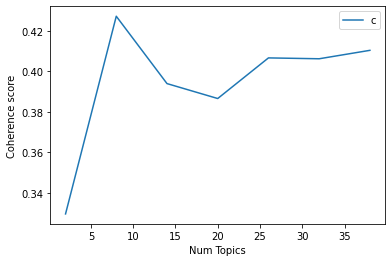

In [117]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [118]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3297
Num Topics = 8  has Coherence Value of 0.4272
Num Topics = 14  has Coherence Value of 0.394
Num Topics = 20  has Coherence Value of 0.3866
Num Topics = 26  has Coherence Value of 0.4066
Num Topics = 32  has Coherence Value of 0.4062
Num Topics = 38  has Coherence Value of 0.4104


In [119]:
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=8, id2word=id2word)

In [120]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

c:\Users\yarem\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.092439 -0.069346       1        1  20.820870
4      0.094965  0.168268       2        1  20.758235
7      0.118580  0.040265       3        1  18.541660
0      0.062138 -0.057530       4        1  12.343182
2      0.073385 -0.092670       5        1  10.777017
6      0.071437 -0.092229       6        1   9.592892
5     -0.136680  0.173076       7        1   4.242613
1     -0.376263 -0.069834       8        1   2.923531, topic_info=          Term         Freq        Total Category  logprob  loglift
5144    вкусно  3016.000000  3016.000000  Default  30.0000  30.0000
2249   позитив  6278.000000  6278.000000  Default  29.0000  29.0000
8859      офис  3626.000000  3626.000000  Default  28.0000  28.0000
15643     омск  2614.000000  2614.000000  Default  27.0000  27.0000
3      уходить  6001.000000  6001.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1668     рынок    12.922666    95.112834   Topic8  -6.8372   1.5363
5418    аромат    11.557286    77.254503   Topic8  -6.9489   1.6326
8859      офис    24.014634  3626.010751   Topic8  -6.2175  -1.4848
6521    полныи     8.827280    35.128850   Topic8  -7.2183   2.1512
7819      вкус     9.321706   116.398309   Topic8  -7.1638   1.0077

[566 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
287       1  0.095094        _
287       2  0.005283        _
287       3  0.001057        _
287       4  0.754416        _
287       5  0.033811        _
...     ...       ...      ...
1591      3  0.008059   эффект
1591      5  0.024177   эффект
6691      2  0.985123     юлия
3023      5  0.979963     яицо
851       6  0.961599  ярослав

[1717 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 8, 1, 3, 7, 6, 2])

In [121]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(10)

C:\Users\yarem\AppData\Local\Temp\ipykernel_17196\2965365211.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\yarem\AppData\Local\Temp\ipykernel_17196\2965365211.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.5695,"позитив, уходить, офис, ребенок, мужчина, люде...","когда-то было именно так , как не хочется чтоб..."
1,1,6,0.4613,"хороший, осень, тесто, лето, друг, иисус, праз...","Настюха , это похоже ты в детстве ))))))))))))..."
2,2,3,0.8546,"кожа, loc, крем, средство, тело, amp, косметик...",1 класс Математика 1нед Решение задач в два де...
3,3,4,0.3874,"позитив, уходить, офис, ребенок, мужчина, люде...",РУССКИЙ АЛФАВИТ ИЛИ АЗБУКА УРОК РУССКОГО ЯЗЫКА...
4,4,0,0.8749,"https, com, id, amp, vk, _, ru, http, mid, искать",Спасать свои автомобили от огня пришлось жител...
5,5,7,0.9131,"любить, день, любовь, рождение, человек, пусть...","Сына, ждем домой!С Днем варенья тебя!Приезжай ..."
6,6,4,0.9026,"позитив, уходить, офис, ребенок, мужчина, люде...","45-лет 20 назад мне казалось, что это так мног..."
7,7,0,0.7791,"https, com, id, amp, vk, _, ru, http, mid, искать","Звоните в ""Круиз"" Грузоперевозка у нас : НАШИ ..."
8,8,6,0.5855,"хороший, осень, тесто, лето, друг, иисус, праз...",30.07.2016 г. Выборг Всероссийская выставка со...
9,9,2,0.6373,"размер, цена, месяц, писать, масло, качество, ...","г. Москва, Помет от известнейших Интерчемпионо..."


In [122]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4,"позитив, уходить, офис, ребенок, мужчина, люде...",2654.0,0.1327
1,6,"хороший, осень, тесто, лето, друг, иисус, праз...",605.0,0.0302
2,3,"кожа, loc, крем, средство, тело, amp, косметик...",2417.0,0.1208
3,4,"позитив, уходить, офис, ребенок, мужчина, люде...",3006.0,0.1503
4,0,"https, com, id, amp, vk, _, ru, http, mid, искать",3337.0,0.1668
...,...,...,...,...
19996,2,"размер, цена, месяц, писать, масло, качество, ...",NaN,NaN
19997,1,"омск, суперпохудение, сетевоиэтомое, nleva, en...",NaN,NaN
19998,3,"кожа, loc, крем, средство, тело, amp, косметик...",NaN,NaN
19999,3,"кожа, loc, крем, средство, тело, amp, косметик...",NaN,NaN


In [123]:
for i, j in zip(df_dominant_topics['Topic_Keywords'][:14], df_dominant_topics['Num_Documents']):
    print(i)

позитив, уходить, офис, ребенок, мужчина, людей, женщина, каждый, новый, любовь
хороший, осень, тесто, лето, друг, иисус, праздник, команда, конкурс, солнечный
кожа, loc, крем, средство, тело, amp, косметика, ru, магазин, лицо
позитив, уходить, офис, ребенок, мужчина, людей, женщина, каждый, новый, любовь
https, com, id, amp, vk, _, ru, http, mid, искать
любить, день, любовь, рождение, человек, пусть, друг, девочка, мама, здоровье
позитив, уходить, офис, ребенок, мужчина, людей, женщина, каждый, новый, любовь
https, com, id, amp, vk, _, ru, http, mid, искать
хороший, осень, тесто, лето, друг, иисус, праздник, команда, конкурс, солнечный
размер, цена, месяц, писать, масло, качество, см, заказ, цвет, приглашать
кожа, loc, крем, средство, тело, amp, косметика, ru, магазин, лицо
вкусно, офис, адреналин, уходить, energydiet, nleva, суперпохудение, сетевоиэтомое, пополнение, друг
хороший, осень, тесто, лето, друг, иисус, праздник, команда, конкурс, солнечный
хороший, осень, тесто, лето, друг

In [74]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,7,"id, привет, блин, хотеть, приветик, сегодня, т...",1778.0,0.0889
1,10,"xd, писать, ето, встречаться, наш, первый, сук...",746.0,0.0373
2,12,"любить, _, мой, ты, очень, спасибо, это, быть,...",624.0,0.0312
3,11,"знать, это, помнить, сказать, ахи, завтра, моч...",750.0,0.0375
4,5,"пойти, написать, супер, приезжать, оч, почему,...",607.0,0.0304
...,...,...,...,...
19995,8,"это, человек, понимать, свой, сделать, глаз, т...",NaN,NaN
19996,0,"думать, такой, тело, любить, утро, фильм, сост...",NaN,NaN
19997,12,"любить, _, мой, ты, очень, спасибо, это, быть,...",NaN,NaN
19998,12,"любить, _, мой, ты, очень, спасибо, это, быть,...",NaN,NaN


In [9]:
def lemmatize_sents(sents):
    for sent in sents:
        yield [i for i in stem.lemmatize(sent) if not (re.match(r'[^\w\s]', i) is not None or i ==' ' or i =='\n') ]

In [10]:
dataset_short_lemmatized = list(lemmatize_sents(dataset_short['text']))

In [12]:
cv = CountVectorizer(max_features=1000, stop_words=ru_stopwords)
n_wd = np.array(cv.fit_transform(list(dataset['text'])[:500_000]).todense()).T
vocabulary = cv.get_feature_names_out ()

c:\Users\yarem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
# bv = artm.BatchVectorizer(data_format='bow_n_wd',
#                           n_wd=n_wd,
#                           vocabulary=vocabulary)

In [36]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

'þты'

In [6]:
import yaml
with open('topics_20000_45_1.yaml','r') as f:
    l_45_1 = yaml.safe_load(f)
with open('topics_20000.yaml','r') as f:
    l_17_1 = yaml.safe_load(f)

In [9]:
l_45_1

{0: '0.026*"омск" + 0.013*"любить" + 0.010*"ребенок" + 0.008*"женщина" + 0.007*"компания" + 0.007*"месяц" + 0.007*"хороший" + 0.007*"друг" + 0.007*"каждый" + 0.007*"новый"',
 1: '0.030*"вкусно" + 0.024*"позитив" + 0.014*"адреналин" + 0.008*"nleva" + 0.008*"сетевоиэтомое" + 0.008*"глаз" + 0.007*"суперпохудение" + 0.007*"быстро" + 0.007*"energydiet" + 0.007*"лицо"',
 2: '0.019*"офис" + 0.018*"уходить" + 0.013*"_" + 0.009*"com" + 0.009*"сеичас" + 0.008*"ru" + 0.008*"цена" + 0.008*"косметика" + 0.008*"id" + 0.008*"vk"',
 3: '0.010*"человек" + 0.009*"amp" + 0.009*"кожа" + 0.009*"средство" + 0.007*"крем" + 0.007*"качество" + 0.007*"своеи" + 0.006*"тело" + 0.006*"результат" + 0.005*"начинать"',
 4: '0.010*"украина" + 0.007*"новосибирск" + 0.006*"страна" + 0.006*"бизнес" + 0.006*"начинаться" + 0.005*"солнце" + 0.005*"земля" + 0.005*"год" + 0.004*"идти" + 0.004*"слово"'}

In [10]:
for i in l_17_1:
    print(f'{i}: {l_17_1[i]}')

0: 0.095*"мир" + 0.088*"мы" + 0.062*"надеяться" + 0.060*"место" + 0.041*"видео" + 0.040*"часто" + 0.024*"весело" + 0.021*"прекрасныи" + 0.013*"роль" + 0.004*"сыграть"
1: 0.400*"хотеть" + 0.097*"жить" + 0.024*"ребенок" + 0.013*"папа" + 0.009*"похожий" + 0.006*"красиво" + 0.006*"легкий" + 0.004*"внутри" + 0.000*"который" + 0.000*"тобой"
2: 0.192*"понимать" + 0.089*"никто" + 0.084*"нужный" + 0.026*"март" + 0.024*"кроме" + 0.006*"кровь" + 0.000*"который" + 0.000*"ходить" + 0.000*"комната" + 0.000*"начинать"
3: 0.067*"вернуть" + 0.055*"домои" + 0.030*"вода" + 0.023*"забирать" + 0.021*"детея" + 0.016*"ухо" + 0.014*"пиздец" + 0.009*"женя" + 0.004*"ржать" + 0.000*"русалка"
4: 0.209*"знать" + 0.162*"твой" + 0.052*"слово" + 0.052*"рядом" + 0.048*"девочка" + 0.048*"лишь" + 0.031*"улыбка" + 0.020*"история" + 0.018*"чужой" + 0.010*"взгляд"
5: 0.335*"_" + 0.071*"самый" + 0.061*"хороший" + 0.040*"один" + 0.033*"спать" + 0.028*"скоро" + 0.027*"ночь" + 0.022*"оставаться" + 0.022*"вместе" + 0.020*"самыя